# sprint 機械学習スクラッチ 線形回帰

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter, lr, bias=None, verbose=None):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        # self.coef_ = None とすることで、fitをを呼び出さなくてもcoefが使用できる（先にpredictやる時とか）
        # self/h0も同様

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # yの一次元化
        y = y.ravel()
        y_val = y_val.ravel()
        
        # 切片列を追加（切片の有無を選べる）
        if not self.bias:   
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
            X_val = np.concatenate([np.ones([X_val.shape[0], 1]), X_val], axis=1)
        
        #パラメーターの初期値（平均０、分散１の正規分布）
        self.coef_ = np.random.normal(0, 1, X.shape[1])
        
        for iter_count in range(self.iter):
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("{}回目の学習".format(iter_count))
            
            # 過程関数
            h0 = _linear_hypothesis(self, X)
            h0_val = _linear_hypothesis(self, X_val)
            # _linear_hypothesis　→　これだけでh0の更新、fit内部ではself.h0で更新後の値が呼び出せる、retunいらない
            # 関数を呼び出すときはself.で呼び出し、引数にself.を使用しない
            
            # 最急降下法（error算出→勾配算出）
            error = h0 - y
            self.coef_ = _gradient_descent(self, X, error)
            # self._gradient_descent →　これだけでself.coef_の更新、fit内部ではself.coef_で更新後の値が呼び出せる、retunいらない
            # 関数を呼び出すときはself.で呼び出し、引数にself.を使用しない
            
            # costの記録
            self.loss[iter_count] = loss_cal(h0 , y)
            self.val_loss[iter_count] = loss_cal(h0_val , y_val)
        

    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        
        h0 = np.dot(X, self.coef_.T)
        
        return h0


# 【問題1】仮定関数
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

In [3]:
def _linear_hypothesis(self, X):
    """
    線形の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    
    Attributes
    ----------
      
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター

    Returns
    -------
    h0 : 次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果

    """

    h0 = np.dot(X, self.coef_.T)
    # coef_.Tでベクトルを転置すると予期せぬ結果が発生する
    # →　だからベクトルの内積時は次元追加の方が良い（newaxis or reshape）
    
    return h0

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

In [4]:
def _gradient_descent(self, X, error):
    """
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    
    error : 次の形のndarray, shape (n_samples, 1)
      trueとpredictの差
      
    self.lr : float
      学習率
    
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター
    
    Returns
    -------
    self.theta_ : 次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果
      
    """
    
    self.coef_ = self.coef_ - self.lr*np.dot(X.T, error)/X.shape[0]
    
    return self.coef_

# 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。

仮定関数 hθ(x)の出力が推定結果です。

# 【問題4】平均二乗誤差
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。

平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。

平均二乗誤差は以下の数式で表されます。

In [5]:
 def MSE(y_pred, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = ((y_pred-y)**2).sum() / X.shape[0]

    return mse

# 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

目的関数（損失関数） J(θ)は次の式です。

In [6]:
def loss_cal(y_pred , y):
    """
    損失関数の計算と記録

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    cost : numpy.float
      平均二乗誤差
    """
    loss = ((y_pred-y)**2).sum() / X.shape[0] / 2
    
    return loss

# 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

In [129]:
# データセットの準備
df_origin = pd.read_csv("../example_input/house_prices/train.csv")
df = df_origin[["GrLivArea", "YearBuilt", "SalePrice"]]
X = df[["GrLivArea", "YearBuilt"]]
y = df[["SalePrice"]]

# 分割
from sklearn.model_selection import train_test_split
# ndarray変換
X_array = X.values
y_array = y.values
X_train, X_valid, y_train, y_valid = train_test_split(
    X_array, y_array, test_size=0.25, random_state=0)

# 各特徴量の標準化
# X、yを分けてインスタンス化
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_std = scaler_X.fit_transform(X_train)
X_valid_std = scaler_X.transform(X_valid)
y_train_std = scaler_y.fit_transform(y_train)
y_valid_std = scaler_y.transform(y_valid)

## 対数などによる正規分布化は行なっていない

In [12]:
# スクラッチの学習
slrg = ScratchLinearRegression(5000, 0.001)
slrg.fit(X_train_std, y_train_std, X_valid_std, y_valid_std)

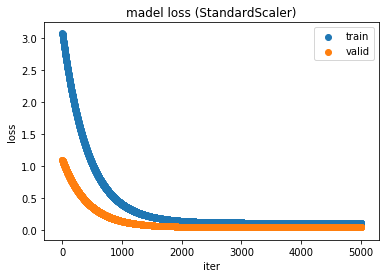

In [13]:
# グラフ化
iter_list = [i for i in range(slrg.iter)]
plt.scatter(iter_list, slrg.loss, label="train")
plt.scatter(iter_list, slrg.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (StandardScaler)')
plt.legend();

In [100]:
# 最終的なloss
print("trainのloss : {}".format(slrg.loss[-1]))
print("validのloss : {}".format(slrg.val_loss[-1]))

trainのloss : 0.12120540261247006
validのloss : 0.05461808479973173


# 【問題8】（アドバンス課題）バイアス項の除去
バイアス項 θ0を抜くと学習がどう変化するか検証してください。また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

In [14]:
# バイアス項なし、学習過程あり　学習
slrg_no_bai = ScratchLinearRegression(5000, 0.001, True, True)
slrg_no_bai.fit(X_train_std, y_train_std, X_valid_std, y_valid_std)

0回目の学習
1回目の学習
2回目の学習
3回目の学習
4回目の学習
5回目の学習
6回目の学習
7回目の学習
8回目の学習
9回目の学習
10回目の学習
11回目の学習
12回目の学習
13回目の学習
14回目の学習
15回目の学習
16回目の学習
17回目の学習
18回目の学習
19回目の学習
20回目の学習
21回目の学習
22回目の学習
23回目の学習
24回目の学習
25回目の学習
26回目の学習
27回目の学習
28回目の学習
29回目の学習
30回目の学習
31回目の学習
32回目の学習
33回目の学習
34回目の学習
35回目の学習
36回目の学習
37回目の学習
38回目の学習
39回目の学習
40回目の学習
41回目の学習
42回目の学習
43回目の学習
44回目の学習
45回目の学習
46回目の学習
47回目の学習
48回目の学習
49回目の学習
50回目の学習
51回目の学習
52回目の学習
53回目の学習
54回目の学習
55回目の学習
56回目の学習
57回目の学習
58回目の学習
59回目の学習
60回目の学習
61回目の学習
62回目の学習
63回目の学習
64回目の学習
65回目の学習
66回目の学習
67回目の学習
68回目の学習
69回目の学習
70回目の学習
71回目の学習
72回目の学習
73回目の学習
74回目の学習
75回目の学習
76回目の学習
77回目の学習
78回目の学習
79回目の学習
80回目の学習
81回目の学習
82回目の学習
83回目の学習
84回目の学習
85回目の学習
86回目の学習
87回目の学習
88回目の学習
89回目の学習
90回目の学習
91回目の学習
92回目の学習
93回目の学習
94回目の学習
95回目の学習
96回目の学習
97回目の学習
98回目の学習
99回目の学習
100回目の学習
101回目の学習
102回目の学習
103回目の学習
104回目の学習
105回目の学習
106回目の学習
107回目の学習
108回目の学習
109回目の学習
110回目の学習
111回目の学習
112回目の学習
113回目の学習
114回目の学習
115回目の学習
116回目の学習
117回目の学習
118回目の学習
119回目の学習
120回目の学習
121回目の学習
122回目の学習
123

1660回目の学習
1661回目の学習
1662回目の学習
1663回目の学習
1664回目の学習
1665回目の学習
1666回目の学習
1667回目の学習
1668回目の学習
1669回目の学習
1670回目の学習
1671回目の学習
1672回目の学習
1673回目の学習
1674回目の学習
1675回目の学習
1676回目の学習
1677回目の学習
1678回目の学習
1679回目の学習
1680回目の学習
1681回目の学習
1682回目の学習
1683回目の学習
1684回目の学習
1685回目の学習
1686回目の学習
1687回目の学習
1688回目の学習
1689回目の学習
1690回目の学習
1691回目の学習
1692回目の学習
1693回目の学習
1694回目の学習
1695回目の学習
1696回目の学習
1697回目の学習
1698回目の学習
1699回目の学習
1700回目の学習
1701回目の学習
1702回目の学習
1703回目の学習
1704回目の学習
1705回目の学習
1706回目の学習
1707回目の学習
1708回目の学習
1709回目の学習
1710回目の学習
1711回目の学習
1712回目の学習
1713回目の学習
1714回目の学習
1715回目の学習
1716回目の学習
1717回目の学習
1718回目の学習
1719回目の学習
1720回目の学習
1721回目の学習
1722回目の学習
1723回目の学習
1724回目の学習
1725回目の学習
1726回目の学習
1727回目の学習
1728回目の学習
1729回目の学習
1730回目の学習
1731回目の学習
1732回目の学習
1733回目の学習
1734回目の学習
1735回目の学習
1736回目の学習
1737回目の学習
1738回目の学習
1739回目の学習
1740回目の学習
1741回目の学習
1742回目の学習
1743回目の学習
1744回目の学習
1745回目の学習
1746回目の学習
1747回目の学習
1748回目の学習
1749回目の学習
1750回目の学習
1751回目の学習
1752回目の学習
1753回目の学習
1754回目の学習
1755回目の学習
1756回目の学習
1757回目の学習
1758回目の学習
1759回目の学習


2587回目の学習
2588回目の学習
2589回目の学習
2590回目の学習
2591回目の学習
2592回目の学習
2593回目の学習
2594回目の学習
2595回目の学習
2596回目の学習
2597回目の学習
2598回目の学習
2599回目の学習
2600回目の学習
2601回目の学習
2602回目の学習
2603回目の学習
2604回目の学習
2605回目の学習
2606回目の学習
2607回目の学習
2608回目の学習
2609回目の学習
2610回目の学習
2611回目の学習
2612回目の学習
2613回目の学習
2614回目の学習
2615回目の学習
2616回目の学習
2617回目の学習
2618回目の学習
2619回目の学習
2620回目の学習
2621回目の学習
2622回目の学習
2623回目の学習
2624回目の学習
2625回目の学習
2626回目の学習
2627回目の学習
2628回目の学習
2629回目の学習
2630回目の学習
2631回目の学習
2632回目の学習
2633回目の学習
2634回目の学習
2635回目の学習
2636回目の学習
2637回目の学習
2638回目の学習
2639回目の学習
2640回目の学習
2641回目の学習
2642回目の学習
2643回目の学習
2644回目の学習
2645回目の学習
2646回目の学習
2647回目の学習
2648回目の学習
2649回目の学習
2650回目の学習
2651回目の学習
2652回目の学習
2653回目の学習
2654回目の学習
2655回目の学習
2656回目の学習
2657回目の学習
2658回目の学習
2659回目の学習
2660回目の学習
2661回目の学習
2662回目の学習
2663回目の学習
2664回目の学習
2665回目の学習
2666回目の学習
2667回目の学習
2668回目の学習
2669回目の学習
2670回目の学習
2671回目の学習
2672回目の学習
2673回目の学習
2674回目の学習
2675回目の学習
2676回目の学習
2677回目の学習
2678回目の学習
2679回目の学習
2680回目の学習
2681回目の学習
2682回目の学習
2683回目の学習
2684回目の学習
2685回目の学習
2686回目の学習


3553回目の学習
3554回目の学習
3555回目の学習
3556回目の学習
3557回目の学習
3558回目の学習
3559回目の学習
3560回目の学習
3561回目の学習
3562回目の学習
3563回目の学習
3564回目の学習
3565回目の学習
3566回目の学習
3567回目の学習
3568回目の学習
3569回目の学習
3570回目の学習
3571回目の学習
3572回目の学習
3573回目の学習
3574回目の学習
3575回目の学習
3576回目の学習
3577回目の学習
3578回目の学習
3579回目の学習
3580回目の学習
3581回目の学習
3582回目の学習
3583回目の学習
3584回目の学習
3585回目の学習
3586回目の学習
3587回目の学習
3588回目の学習
3589回目の学習
3590回目の学習
3591回目の学習
3592回目の学習
3593回目の学習
3594回目の学習
3595回目の学習
3596回目の学習
3597回目の学習
3598回目の学習
3599回目の学習
3600回目の学習
3601回目の学習
3602回目の学習
3603回目の学習
3604回目の学習
3605回目の学習
3606回目の学習
3607回目の学習
3608回目の学習
3609回目の学習
3610回目の学習
3611回目の学習
3612回目の学習
3613回目の学習
3614回目の学習
3615回目の学習
3616回目の学習
3617回目の学習
3618回目の学習
3619回目の学習
3620回目の学習
3621回目の学習
3622回目の学習
3623回目の学習
3624回目の学習
3625回目の学習
3626回目の学習
3627回目の学習
3628回目の学習
3629回目の学習
3630回目の学習
3631回目の学習
3632回目の学習
3633回目の学習
3634回目の学習
3635回目の学習
3636回目の学習
3637回目の学習
3638回目の学習
3639回目の学習
3640回目の学習
3641回目の学習
3642回目の学習
3643回目の学習
3644回目の学習
3645回目の学習
3646回目の学習
3647回目の学習
3648回目の学習
3649回目の学習
3650回目の学習
3651回目の学習
3652回目の学習


4526回目の学習
4527回目の学習
4528回目の学習
4529回目の学習
4530回目の学習
4531回目の学習
4532回目の学習
4533回目の学習
4534回目の学習
4535回目の学習
4536回目の学習
4537回目の学習
4538回目の学習
4539回目の学習
4540回目の学習
4541回目の学習
4542回目の学習
4543回目の学習
4544回目の学習
4545回目の学習
4546回目の学習
4547回目の学習
4548回目の学習
4549回目の学習
4550回目の学習
4551回目の学習
4552回目の学習
4553回目の学習
4554回目の学習
4555回目の学習
4556回目の学習
4557回目の学習
4558回目の学習
4559回目の学習
4560回目の学習
4561回目の学習
4562回目の学習
4563回目の学習
4564回目の学習
4565回目の学習
4566回目の学習
4567回目の学習
4568回目の学習
4569回目の学習
4570回目の学習
4571回目の学習
4572回目の学習
4573回目の学習
4574回目の学習
4575回目の学習
4576回目の学習
4577回目の学習
4578回目の学習
4579回目の学習
4580回目の学習
4581回目の学習
4582回目の学習
4583回目の学習
4584回目の学習
4585回目の学習
4586回目の学習
4587回目の学習
4588回目の学習
4589回目の学習
4590回目の学習
4591回目の学習
4592回目の学習
4593回目の学習
4594回目の学習
4595回目の学習
4596回目の学習
4597回目の学習
4598回目の学習
4599回目の学習
4600回目の学習
4601回目の学習
4602回目の学習
4603回目の学習
4604回目の学習
4605回目の学習
4606回目の学習
4607回目の学習
4608回目の学習
4609回目の学習
4610回目の学習
4611回目の学習
4612回目の学習
4613回目の学習
4614回目の学習
4615回目の学習
4616回目の学習
4617回目の学習
4618回目の学習
4619回目の学習
4620回目の学習
4621回目の学習
4622回目の学習
4623回目の学習
4624回目の学習
4625回目の学習


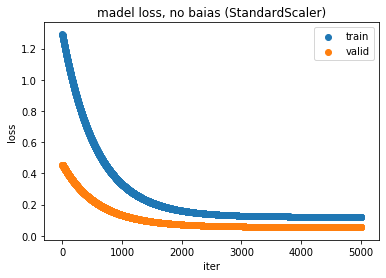

In [15]:
# グラフ化、バイアス項なし
iter_no_bai_list = [i for i in range(slrg_no_bai.iter)]
plt.scatter(iter_no_bai_list, slrg_no_bai.loss, label="train")
plt.scatter(iter_no_bai_list, slrg_no_bai.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss, no baias (StandardScaler)')
plt.legend();

In [101]:
# 最終的なloss バイアス項なし
print("trainのloss : {}".format(slrg_no_bai.loss[-1]))
print("validのloss : {}".format(slrg_no_bai.val_loss[-1]))

trainのloss : 0.12143743624120386
validのloss : 0.05540441641888701


# 【問題9】（アドバンス課題）特徴量の多次元化
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

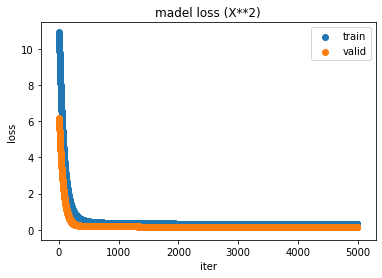

In [102]:
# 特徴量の２乗
slrg_poly2 = ScratchLinearRegression(5000, 0.001)
slrg_poly2.fit(X_train_std**2, y_train_std, X_valid_std**2, y_valid_std)

iter_poly2_list = [i for i in range(slrg_poly2.iter)]
plt.scatter(iter_poly2_list, slrg_poly2.loss, label="train")
plt.scatter(iter_poly2_list, slrg_poly2.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (X**2)')
plt.legend();

In [103]:
# 最終的なloss
print("trainのloss : {}".format(slrg_poly2.loss[-1]))
print("validのloss : {}".format(slrg_poly2.val_loss[-1]))

trainのloss : 0.3271533375674515
validのloss : 0.1509636870542656


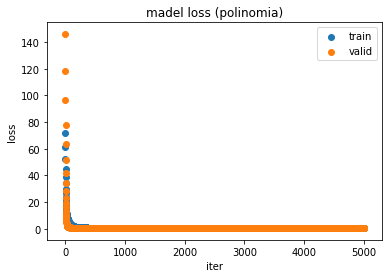

In [104]:
# 特徴量の３乗
slrg_poly3 = ScratchLinearRegression(5000, 0.001)
slrg_poly3.fit(X_train_std**3, y_train_std, X_valid_std**3, y_valid_std)

iter_poly3_list = [i for i in range(slrg_poly3.iter)]
plt.scatter(iter_poly3_list, slrg_poly3.loss, label="train")
plt.scatter(iter_poly3_list, slrg_poly3.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (polinomia)')
plt.legend();

In [105]:
# 最終的なloss
print("trainのloss : {}".format(slrg_poly3.loss[-1]))
print("validのloss : {}".format(slrg_poly3.val_loss[-1]))

trainのloss : 0.29049733440533015
validのloss : 0.23374461503852764


In [113]:
# それぞれの最終的なlossのまとめ
loss = [slrg.loss[-1], slrg.val_loss[-1]]
loss_no = [slrg_no_bai.loss[-1], slrg_no_bai.val_loss[-1]]
loss_poly2 = [slrg_poly2.loss[-1], slrg_poly2.val_loss[-1]]
loss_poly3 = [slrg_poly3.loss[-1], slrg_poly3.val_loss[-1]]

loss_df = pd.DataFrame([loss, loss_no, loss_poly2, loss_poly3],
                      index=['通常', 'バイアスなし', '２乗', '３乗'],
                      columns=['train', 'valid'])
loss_df

,train,valid
通常,0.121205,0.054618
バイアスなし,0.121437,0.055404
２乗,0.327153,0.150964
３乗,0.290497,0.233745


特徴量をべき乗すると最終的なlossが大きい（収束するのは早いが）  
→べき乗にするとグラフではどうなる？

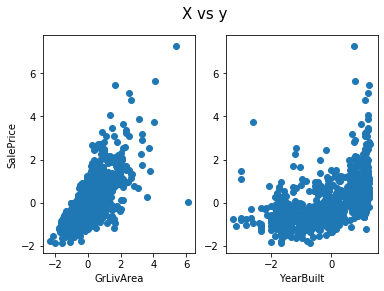

In [92]:
# poly前のグラフ
plt.figure().suptitle("X vs y", size=15)
plt.subplot(121)
plt.scatter(X_train_std[:, 0], y_train_std)
plt.xlabel(X.columns[0])
plt.ylabel(y.columns[0])
plt.subplot(122)
plt.scatter(X_train_std[:, 1], y_train_std)
plt.xlabel(X.columns[1]);

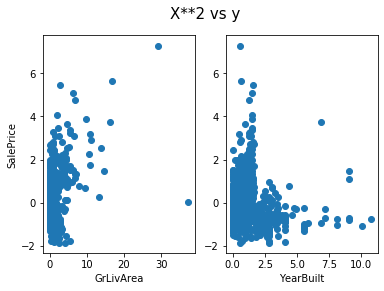

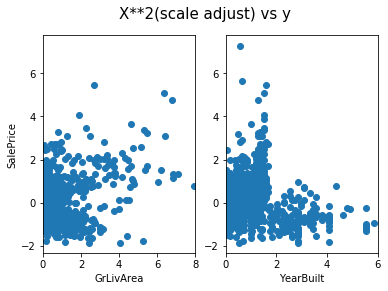

In [124]:
# ２乗のグラフ
plt.figure().suptitle("X**2 vs y", size=15)
plt.subplot(121)
plt.scatter(X_train_std[:, 0]**2, y_train_std)
plt.xlabel(X.columns[0])
plt.ylabel(y.columns[0])
plt.subplot(122)
plt.scatter(X_train_std[:, 1]**2, y_train_std)
plt.xlabel(X.columns[1])

# ２乗のグラフ　スケールを調整
plt.figure().suptitle("X**2(scale adjust) vs y", size=15)
plt.subplot(121)
plt.scatter(X_train_std[:, 0]**2, y_train_std)
plt.xlim(0, 8)
plt.xlabel(X.columns[0])
plt.ylabel(y.columns[0])
plt.subplot(122)
plt.scatter(X_train_std[:, 1]**2, y_train_std)
plt.xlim(0, 6)
plt.xlabel(X.columns[1]);

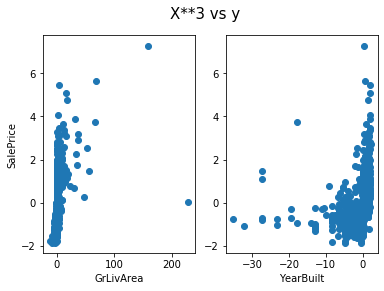

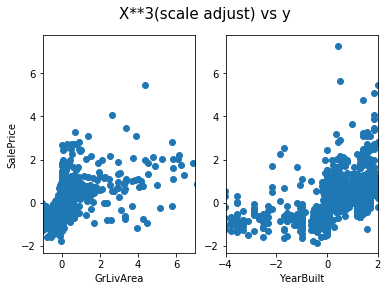

In [127]:
# 3乗のグラフ
plt.figure().suptitle("X**3 vs y", size=15)
plt.subplot(121)
plt.scatter(X_train_std[:, 0]**3, y_train_std)
plt.xlabel(X.columns[0])
plt.ylabel(y.columns[0])
plt.subplot(122)
plt.scatter(X_train_std[:, 1]**3, y_train_std)
plt.xlabel(X.columns[1])

# ２乗のグラフ　スケールを調整
plt.figure().suptitle("X**3(scale adjust) vs y", size=15)
plt.subplot(121)
plt.scatter(X_train_std[:, 0]**3, y_train_std)
plt.xlim(-1, 7)
plt.xlabel(X.columns[0])
plt.ylabel(y.columns[0])
plt.subplot(122)
plt.scatter(X_train_std[:, 1]**3, y_train_std)
plt.xlim(-4, 2)
plt.xlabel(X.columns[1]);

特徴量をべき乗することで分布が疎になる（外れ値が増える）  
線型性も減少している  
→そのため最終的なlossも高くなる（線型性の低下）

# 【問題11】（アドバンス課題）局所最適解の問題
最急降下法には一般的に局所最適解の問題があります。しかし、線形回帰では学習を続ければ必ず最適解を求めることができます。それはなぜか数式やグラフを用いて説明してください。

目的関数である損失関数は、変数に対する２乗の関数。  
そのため、２乗の関数は局所最適解を持たないため必ず最適解が求められる。